<a href="https://colab.research.google.com/github/chachia-wacef/ComputerVision/blob/main/License_Number_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=523c3597b35f3f70241400e1d9e59049c0bc427799d61f81ed26591f5bd45e89
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [9]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import pytesseract as tess

In [4]:
#fonction pour vérifier l'hauteur et la surface
def ratioCheck(area, width, height):
    ratio = float(width) / float(height)
    if ratio < 1:
        ratio = 1 / ratio
    if (area < 1063.62 or area > 73862.5) or (ratio < 3 or ratio > 6):
        return False
    return True

In [5]:
#pour vérifier si la série est en "blanc"(selon l'exp utilisée)
def isMaxWhite(plate):
    avg = np.mean(plate)
    if(avg>=115):
        return True
    else:
         return False

In [6]:
def ratio_and_rotation(rect):
    (x, y), (width, height), rect_angle = rect

    if(width>height):
        angle = -rect_angle
    else:
        angle = 90 + rect_angle

    if angle>15:
         return False

    if height == 0 or width == 0:
        return False

    #calculer la surface du contour    
    area = height*width
    
    if not ratioCheck(area,width,height):
        return False
    else:
        return True

In [7]:
def clean2_plate(plate):
  #convertir l'image en noir_blanc
  gray_img = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
  #diminuer le bruit de l'image
  _, thresh = cv2.threshold(gray_img, 110, 255, cv2.THRESH_BINARY)

  #if cv2.waitKey(0) & 0xff == ord('q'):
  #  pass
  #déterminer tous les contours de l'image
  num_contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  #s'ilya des contours :
  if num_contours:
    #créer liste des calcules des surfaces de chaque contour
    contour_area = [cv2.contourArea(c) for c in num_contours]
    #l'indice de plus grand contour :
    max_cntr_index = np.argmax(contour_area)

    max_cnt = num_contours[max_cntr_index]
    max_cntArea = contour_area[max_cntr_index]
    x,y,w,h = cv2.boundingRect(max_cnt)

    if not ratioCheck(max_cntArea,w,h):
      return plate,None
      
    final_img = thresh[y:y+h, x:x+w]
    return final_img,[x,y,w,h]
  else:
    return plate, None

Number  input image...


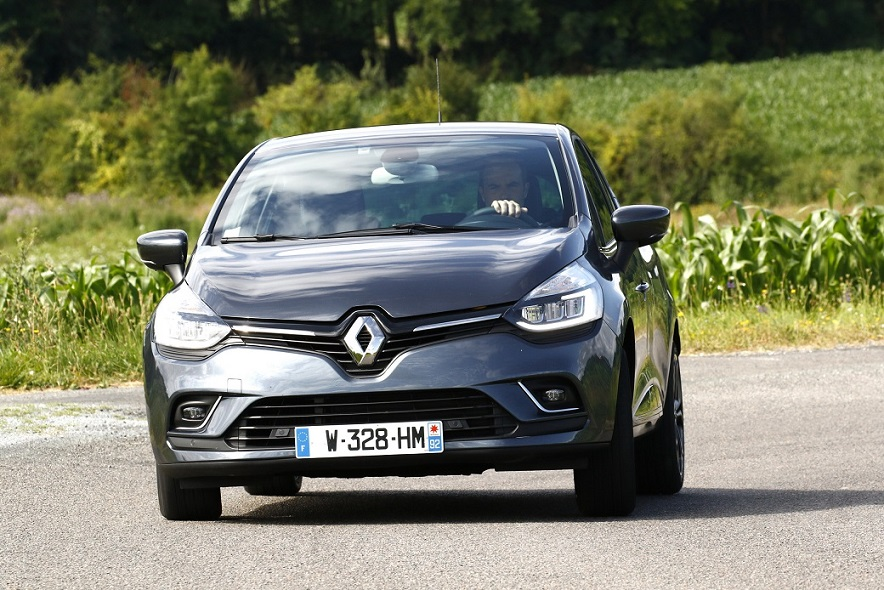

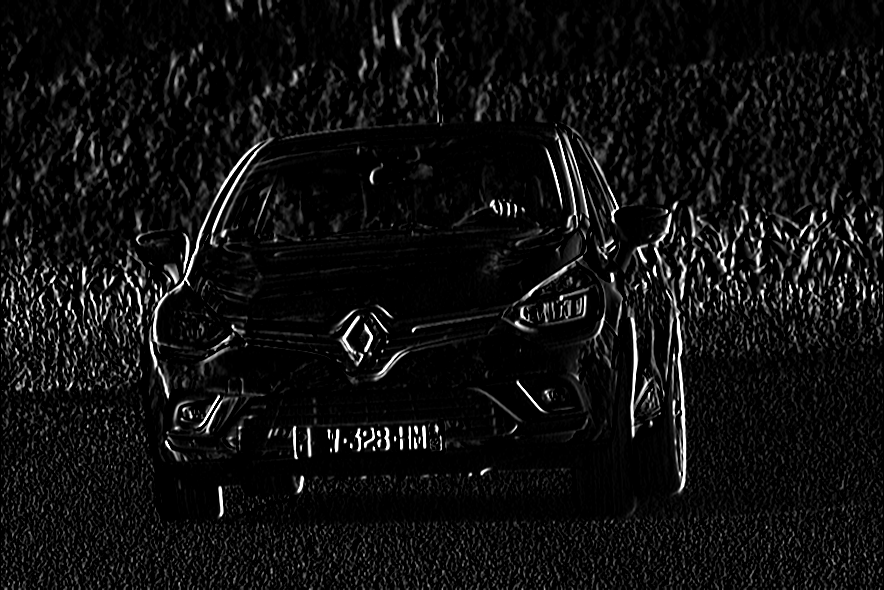

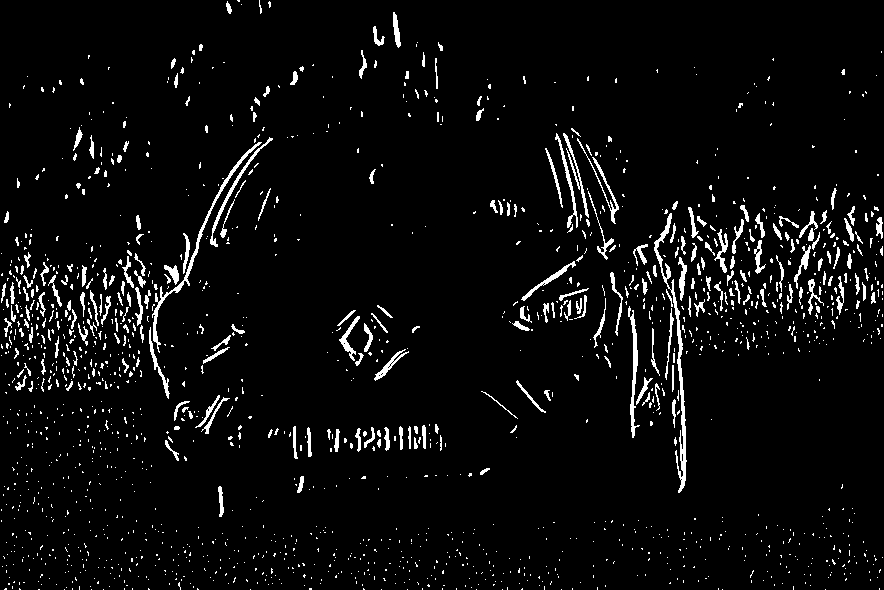

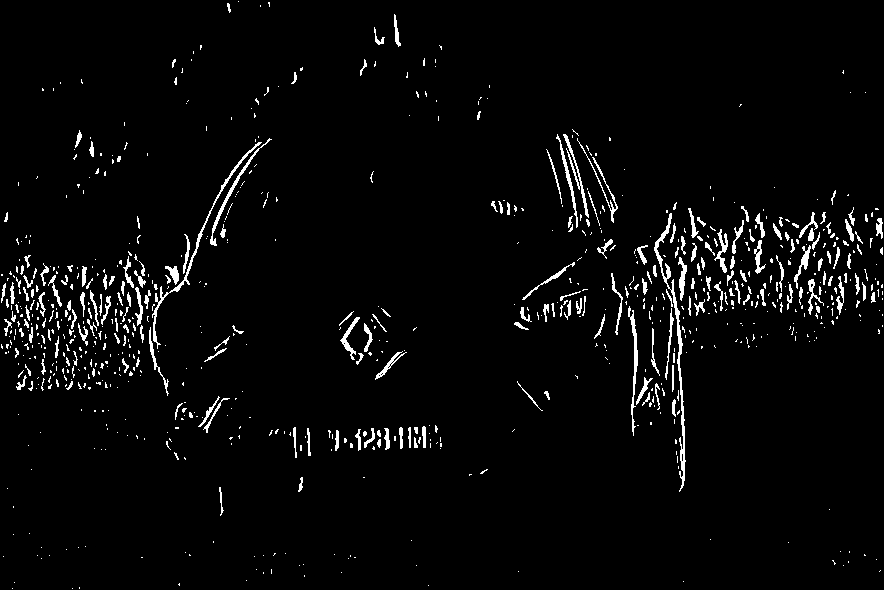

Number  identified number plate...


In [19]:
#code final
#on va afficher l'image aprés chaque opération pour voir le cycle des opérations.
img = cv2.imread("/content/v2.jpg")
print("Number  input image...",)
cv2_imshow(img)

#if cv2.waitKey(0) & 0xff == ord('q'):
#    pass

#traiter l'image
#filter l'image avec un filtre passe bas qui élimine les hauts fréquences
img2 = cv2.GaussianBlur(img, (3,3), 0)
#convertir l'image en noir_blanc
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
#edge detection
img2 = cv2.Sobel(img2,cv2.CV_8U,1,0,ksize=3)  
cv2_imshow(img2)
#diminuer le bruit dans l'image  
_,img2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(img2)
element = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(17, 3))
#une copie de l'image pour étre la destination de l'opération suivante:
morph_img_threshold = img2.copy()
cv2.morphologyEx(src=img2, op=cv2.MORPH_CLOSE, kernel=element, dst=morph_img_threshold)

#déterminer les contours
num_contours, hierarchy= cv2.findContours(morph_img_threshold,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
#dessiner les contours
cv2.drawContours(img2, num_contours, -1, (0,255,0), 1)
cv2_imshow(img2)
#parcourir les contours obtenus
for i,cnt in enumerate(num_contours):
  #déterminer le plus petit rectangle qui entoure cette contour
  min_rect = cv2.minAreaRect(cnt)
  if ratio_and_rotation(min_rect):
    #reetourner les cordonnées du rectangle qui entoure cette contour
    x,y,w,h = cv2.boundingRect(cnt)
    #extraire la partie de l'image du contour
    plate_img = img[y:y+h,x:x+w]
    print("Number  identified number plate...")
    cv2_imshow(plate_img)
    #if cv2.waitKey(0) & 0xff == ord('q'):
    #  pass
    #if(isMaxWhite(plate_img)):
    #  clean_plate, rect = clean2_plate(plate_img)
    #  if rect:
     ##   fg=0
     #   x1,y1,w1,h1 = rect
     #   x,y,w,h = x+x1,y+y1,w1,h1
        # cv2.imwrite("clena.png",clean_plate)
     #   plate_im = Image.fromarray(clean_plate)
     #   text = tess.image_to_string(plate_im, lang='eng')
      #  print("Number  Detected Plate Text : ",text)

In [17]:
#trés bien il marche pour les plates de couleur ""blanc"""
#il faut essayer plus avec cette modéle pour qu'il soit plus efficace avec les images peu claires